In [8]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *

from surprise import NMF
from surprise import Dataset
from surprise.reader import Reader
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
sns.set_theme()

In [9]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 # change to set one

In [3]:
# filter data with the minimum reviews
rev_filter = filter_df(avis_clean, min_reviews)

# create user-game matrix
user_game_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(rev_filter)
filter_games_index = pd.merge(rev_filter["Game id"].drop_duplicates(), games_table_assoc.reset_index(), on="Game id")
filter_users_index = pd.merge(rev_filter["User id"].drop_duplicates(), users_table_assoc.reset_index(), on="User id")

filter_games_index.columns = ["Game id", "Game index"]
filter_users_index.columns = ["User id", "User index"]

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


In [4]:
users_tags = filter_users_index.merge(avis_clean, on="User id").merge(jeux_clean, on="Game id")[["User id", "Type"]]
users_tags["Type"] = users_tags["Type"].str.split("|")
users_tags = users_tags.explode("Type")
users_tags["Type"] = users_tags["Type"].str.strip().str.lower()
users_tags = users_tags.drop_duplicates()

users_tags = users_tags.pivot_table(index="User id", columns="Type", aggfunc="size", fill_value = 0, dropna=False)
users_tags

Type,abstrait,affrontement,afrique,alignement,amateur,ambiance,animaux,antiquité,archive,art,...,tv & cinéma,vampire,vikings,ville,volcan,vote,zombies,équilibre,équipe,NaN
User id,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,0,1,1,1,0,0,...,0,0,0,1,0,0,1,0,0,1
1,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,0,1,...,1,0,0,1,1,0,0,1,1,1
3,1,1,0,1,1,1,1,1,0,1,...,1,0,0,1,1,0,1,0,1,1
4,0,1,0,0,0,1,1,0,0,0,...,1,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9509,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9583,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
9596,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1


## Games tags

In [5]:
games_filter = pd.merge(jeux_clean, filter_games_index, on="Game id")
games_exploded = games_filter.copy()
games_exploded["Type"] = games_filter["Type"].str.split('|')

games_exploded = games_exploded.explode("Type")
games_exploded["Type"] = games_exploded["Type"].str.strip().str.lower()
games_exploded = games_exploded.drop_duplicates()

games_tags = games_exploded.pivot_table(index="Game id", columns="Type", aggfunc='size', fill_value=0, dropna=False)
games_tags

Type,abstrait,affrontement,afrique,alignement,amateur,ambiance,animaux,antiquité,archive,art,...,tv & cinéma,vampire,vikings,ville,volcan,vote,zombies,équilibre,équipe,NaN
Game id,,,,,,,,,,,,,,,,,,,,,
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Delete rare tags

In [429]:
tags_freq = pd.DataFrame(index=games_tags.columns)
tags_freq["Sum"] = games_tags.apply(sum, axis=0)
tags_freq = tags_freq.reset_index().sort_values(by="Sum", ascending=False)

# Delete unpopular tags
tags_filter = tags_freq[tags_freq["Sum"] >= 20]
games_tags = games_tags.loc[:, tags_filter["Type"].values]
users_tags = users_tags.loc[:, tags_filter["Type"].values]
games_tags.shape, tags_filter.shape, users_tags.shape

((2614, 86), (86, 2), (1945, 86))

Text(0, 0.5, 'Number of games')

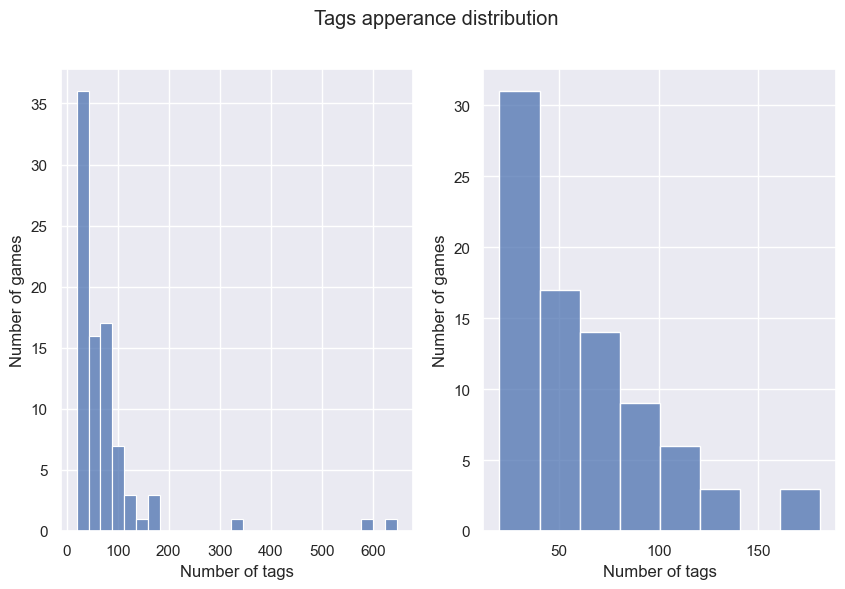

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
#sns.set_theme(rc={'figure.figsize':(6,4)})
sns.histplot(tags_freq["Sum"], ax=ax1)

tags_limit = tags_freq[tags_freq["Sum"] < 200]
sns.histplot(tags_limit["Sum"], ax=ax2)

plt.suptitle("Tags apperance distribution")
ax1.set_xlabel("Number of tags")
ax2.set_xlabel("Number of tags")

ax1.set_ylabel("Number of games")
ax2.set_ylabel("Number of games")


# NNMF

In [12]:
model = NMF(n_factors=30, random_state=42, biased=False, reg_pu= 0.1, reg_qi= 0.1)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
trainset = data.build_full_trainset()
nmf = model.fit(trainset)

# Extract matrices
U = nmf.pu  # User-feature matrix (W)
G = nmf.qi  # Item-feature matrix (H)
G.shape

(2614, 30)

In [17]:
pred = U @ G.T
pred[:5, :5], 

(array([[8.0386378 , 8.89324516, 8.37455159, 9.21862364, 8.73841116],
        [6.65277755, 6.89264477, 6.74549065, 7.32480089, 7.98742321],
        [6.89126245, 8.56060921, 8.0747999 , 8.33219733, 8.07339292],
        [7.18972794, 7.97136048, 8.19965133, 8.45417033, 7.69203681],
        [7.77623703, 8.9573349 , 8.91796052, 9.31494075, 7.57534097]]),)

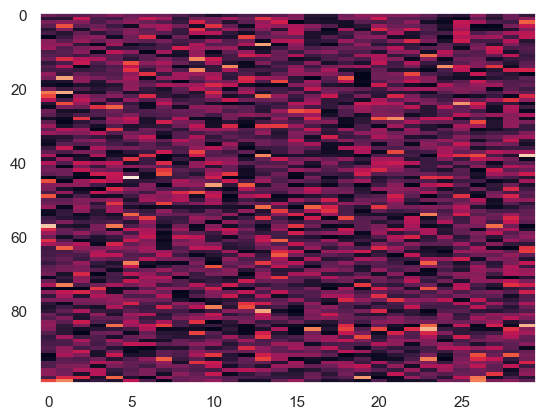

In [14]:
plt.imshow(G[:100, :], aspect="auto")
plt.grid(False)

In [19]:
games_ids = [trainset.to_raw_iid(i) for i in range(len(G))]
users_ids = [trainset.to_raw_uid(u) for u in range(len(U))]
#G[games_ids, :]
len(users_ids)

#games_tags = games_tags.loc[games_ids]
#users_tags = users_tags.loc[users_ids]
users_tags

Type,jeux de plateau,NaN,jeux de cartes,"hasard (dé, cartes, ...)",placement,affrontement,combinaison,gestion,déplacement,médiéval-fantastique,...,renaissance,pirate,historique,jeu de logique,jeux de dés,pari,créativité,transport de marchandise,lettres / mots,zombies
User id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,0,1,0,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1
4,0,1,0,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9509,1,1,1,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9583,1,1,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9596,1,1,0,0,1,1,0,1,1,0,...,0,0,0,0,0,1,0,1,0,1


## Games clustering (NNMF profiles based)

In [257]:
sns.set_theme(rc={"figure.figsize":(6, 4)})
distortions_means = []
centroids_distances = []
nb_clusters = np.arange(5, 60, 5)
for n in nb_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42) 
    kmeans.fit(G) 

    distances = cdist(G, kmeans.cluster_centers_, metric="euclidean")
    
    distances = pd.DataFrame({"Distance_centroid": np.take_along_axis(distances, kmeans.labels_[..., None], axis=1).flatten(),
                              "Cluster": kmeans.labels_})

    mean_distortion = np.mean(distances[["Cluster", "Distance_centroid"]].groupby(by=["Cluster"]).sum().values, axis=0).item()
    distortions_means.append(mean_distortion)
    
    centroids_dist = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric="euclidean")
   
    mean = np.sum(centroids_dist) / (centroids_dist.size - centroids_dist.shape[0])
    centroids_distances.append(mean)
    #scores.append(kmeans.inertia_)

Text(0, 0.5, 'Mean distance')

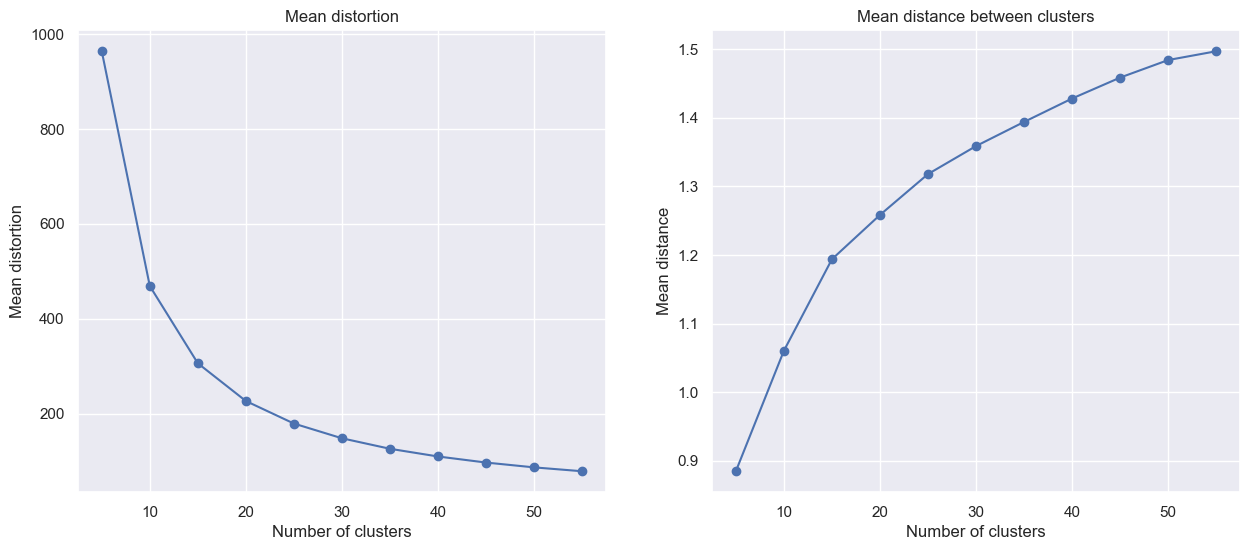

In [258]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(nb_clusters[:20], distortions_means[:20], marker='o')
ax1.set_title("Mean distortion")
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Mean distortion")

ax2.plot(nb_clusters[:20], centroids_distances[:20], marker='o')
ax2.set_title("Mean distance between clusters")
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Mean distance")

<Axes: xlabel='Cluster', ylabel='count'>

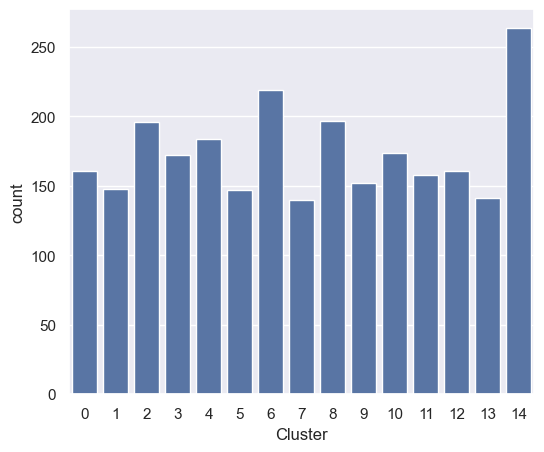

In [337]:
sns.set_theme(rc={"figure.figsize":(6, 5)})
kmeans = KMeans(n_clusters=15, random_state=42) 
kmeans.fit(G) 
game_labels = kmeans.labels_ 

# Distances from centroids (calc to all centroids, then select only necessary)
distances = np.power(cdist(G, kmeans.cluster_centers_, metric="euclidean"), 2)
#games_clusters.merge(distances, left_index=True, left_on=)
games_clusters = pd.DataFrame({"Game id":games_ids,
                        "Distance_centroid": np.take_along_axis(distances, kmeans.labels_[..., None], axis=1).flatten(),
                         "Cluster": kmeans.labels_})
#games_clusters = games_clusters.merge(distances, on="Game id")
#games_clusters
sns.barplot(data=games_clusters["Cluster"].value_counts())

Text(0.5, 1.0, 'Centroids pairwise Eucl dist')

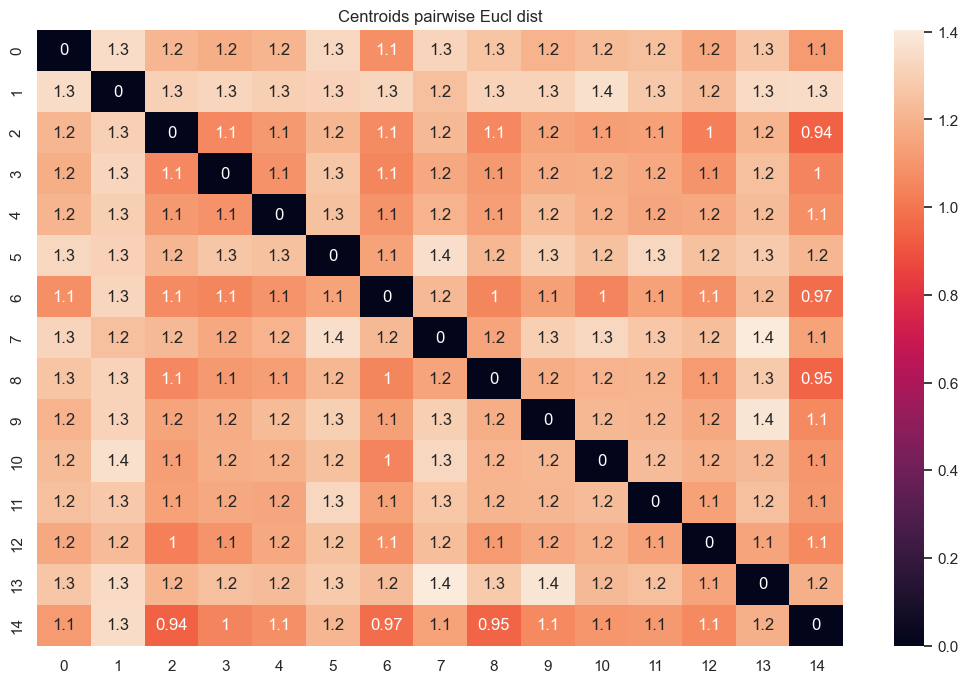

In [338]:
sns.set_theme(rc={"figure.figsize":(13, 8)})
centroids_dist = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric="euclidean")
ax = sns.heatmap(centroids_dist, annot=True)
ax.set_title("Centroids pairwise Eucl dist")

In [339]:
np.sum(centroids_dist) / (centroids_dist.size - centroids_dist.shape[0])

1.193916284033596

### Ratings per cluster

In [ ]:
games_means = rev_filter[["Game id", "Rating"]].groupby("Game id").mean().reset_index()
clusters_ratings = games_clusters.merge(games_means[["Game id", "Rating"]], on="Game id")
means = clusters_ratings[["Cluster", "Rating"]].groupby(by="Cluster").agg(["mean", "std"])
means.columns = means.columns.to_flat_index()
means = means.reset_index()
means.columns

Index(['Cluster', ('Rating', 'mean'), ('Rating', 'std')], dtype='object')

In [ ]:
tags_ratings = tags_filter[["Type"]].merge(games_exploded[["Game id", "Type"]], on="Type").merge(rev_filter[["Game id", "Rating"]], on="Game id")
tags_ratings.groupby("Game id")

,Type,Game id,Rating
0,jeux de plateau,44,10.0
1,jeux de plateau,44,10.0
2,jeux de plateau,44,10.0
3,jeux de plateau,44,10.0
4,jeux de plateau,44,10.0
...,...,...,...
300040,zombies,10425,6.0
300041,zombies,10425,6.0
300042,zombies,10425,6.0
300043,zombies,10425,6.0


Text(0, 0.5, 'Mean, std')

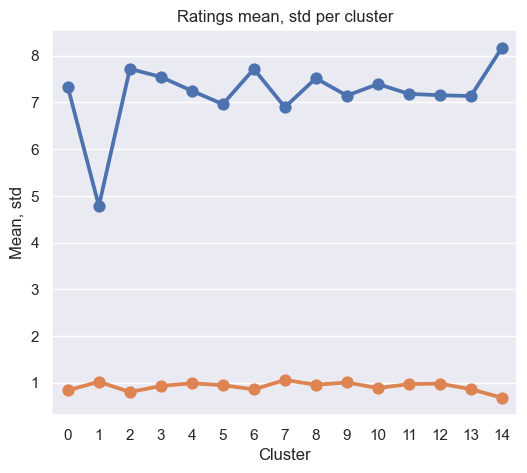

In [341]:
sns.set_theme(rc={"figure.figsize":(6, 5)})
ax = sns.pointplot(data=means, x="Cluster", y=('Rating', 'mean'))
sns.pointplot(data=means, x="Cluster", y=('Rating', 'std'))
ax.set_title("Ratings mean, std per cluster")
ax.set_ylabel("Mean, std")

<Axes: xlabel='Type', ylabel='Cluster'>

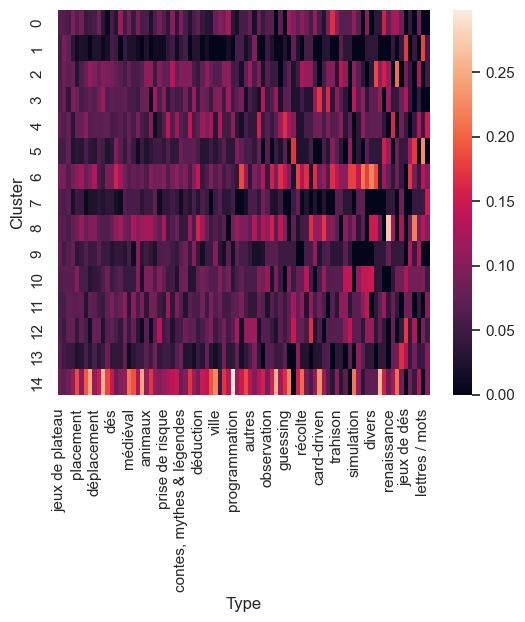

In [342]:
clusters_tags = games_clusters.pivot_table(index="Game id", columns="Cluster", aggfunc='size', fill_value=0).T @ games_tags
clusters_tags_normal = clusters_tags / clusters_tags.sum(axis=0) # normalize
sns.heatmap(clusters_tags_normal)

In [ ]:
clusters_tags_df = clusters_tags_normal.stack().to_frame().reset_index()
clusters_tags_df.columns = ["Cluster", "Type", "Frequency"]
#clusters_tags_df.sort_values()
sorted = clusters_tags_df.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Frequency', ascending=False).head(10))

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_22791/1417634061.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted = clusters_tags_df.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Frequency', ascending=False).head(10))


,Cluster,Type,Frequency
0,0,jeux de plateau,0.066461
1,0,NaN,0.065217
2,0,jeux de cartes,0.057971
3,0,"hasard (dé, cartes, ...)",0.093923
4,0,placement,0.065868
...,...,...,...
1285,14,pari,0.086957
1286,14,créativité,0.043478
1287,14,transport de marchandise,0.130435
1288,14,lettres / mots,0.000000


### Probabilités (=fréquences) d'apparition d'un tag dans chaque cluster

In [423]:
probas_cluster = clusters_tags_df.pivot_table(index="Type", columns="Cluster", values="Frequency")

Text(0.5, 1.0, 'Tags probabilities per cluster')

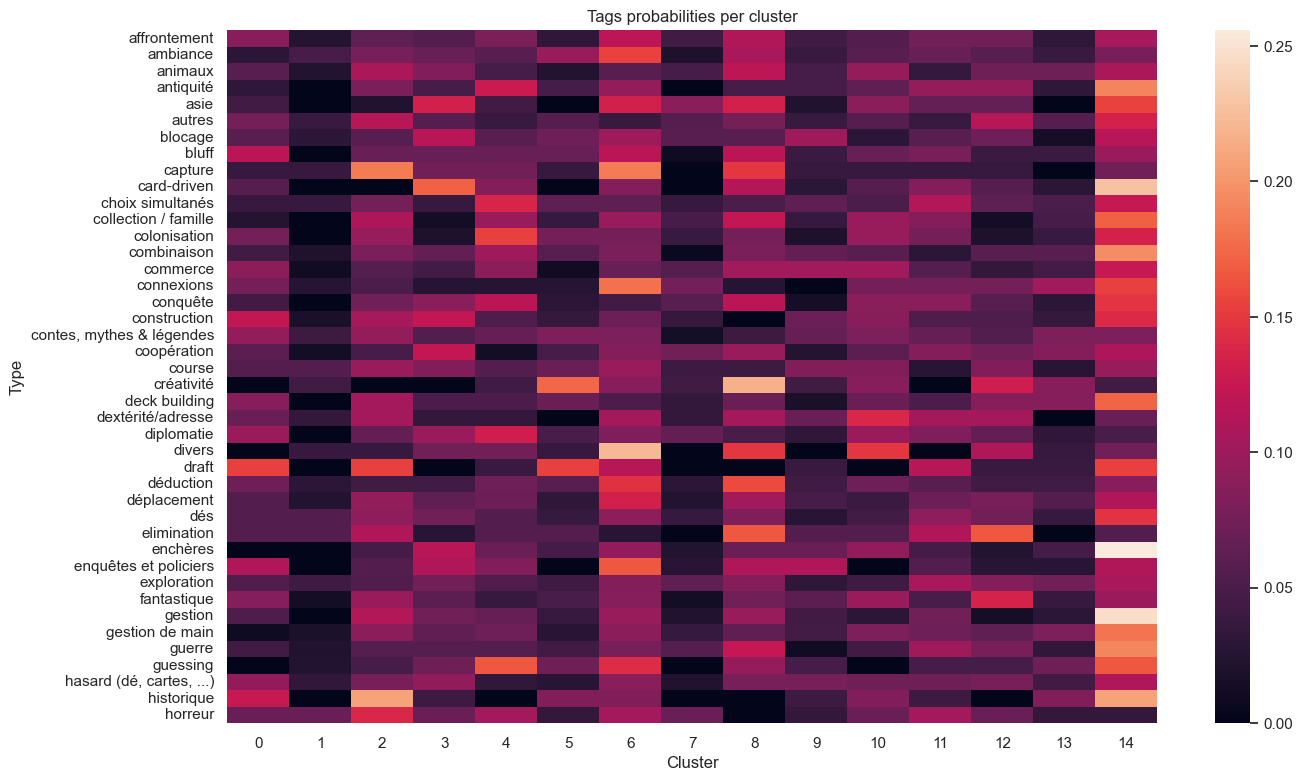

In [ ]:
ax = sns.heatmap(probas_cluster[:42])
ax.set_title("Tags probabilities per cluster (1st half)")

Text(0.5, 1.0, 'Tags probabilities per cluster (2nd half)')

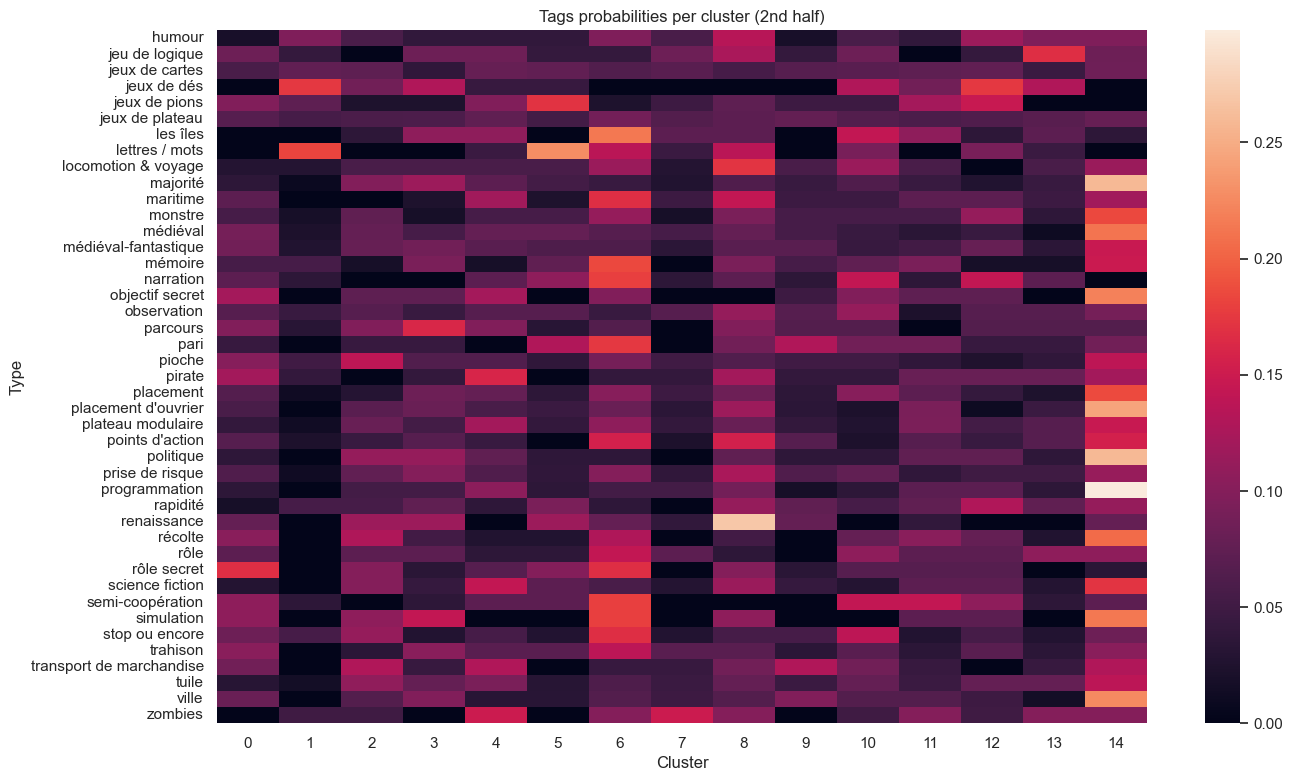

In [425]:
ax = sns.heatmap(probas_cluster[42:])
ax.set_title("Tags probabilities per cluster (2nd half)")

Clusters:

14. Best rated games (almost every category appear frequently)

Text(0.5, 0.98, 'Games clusters')

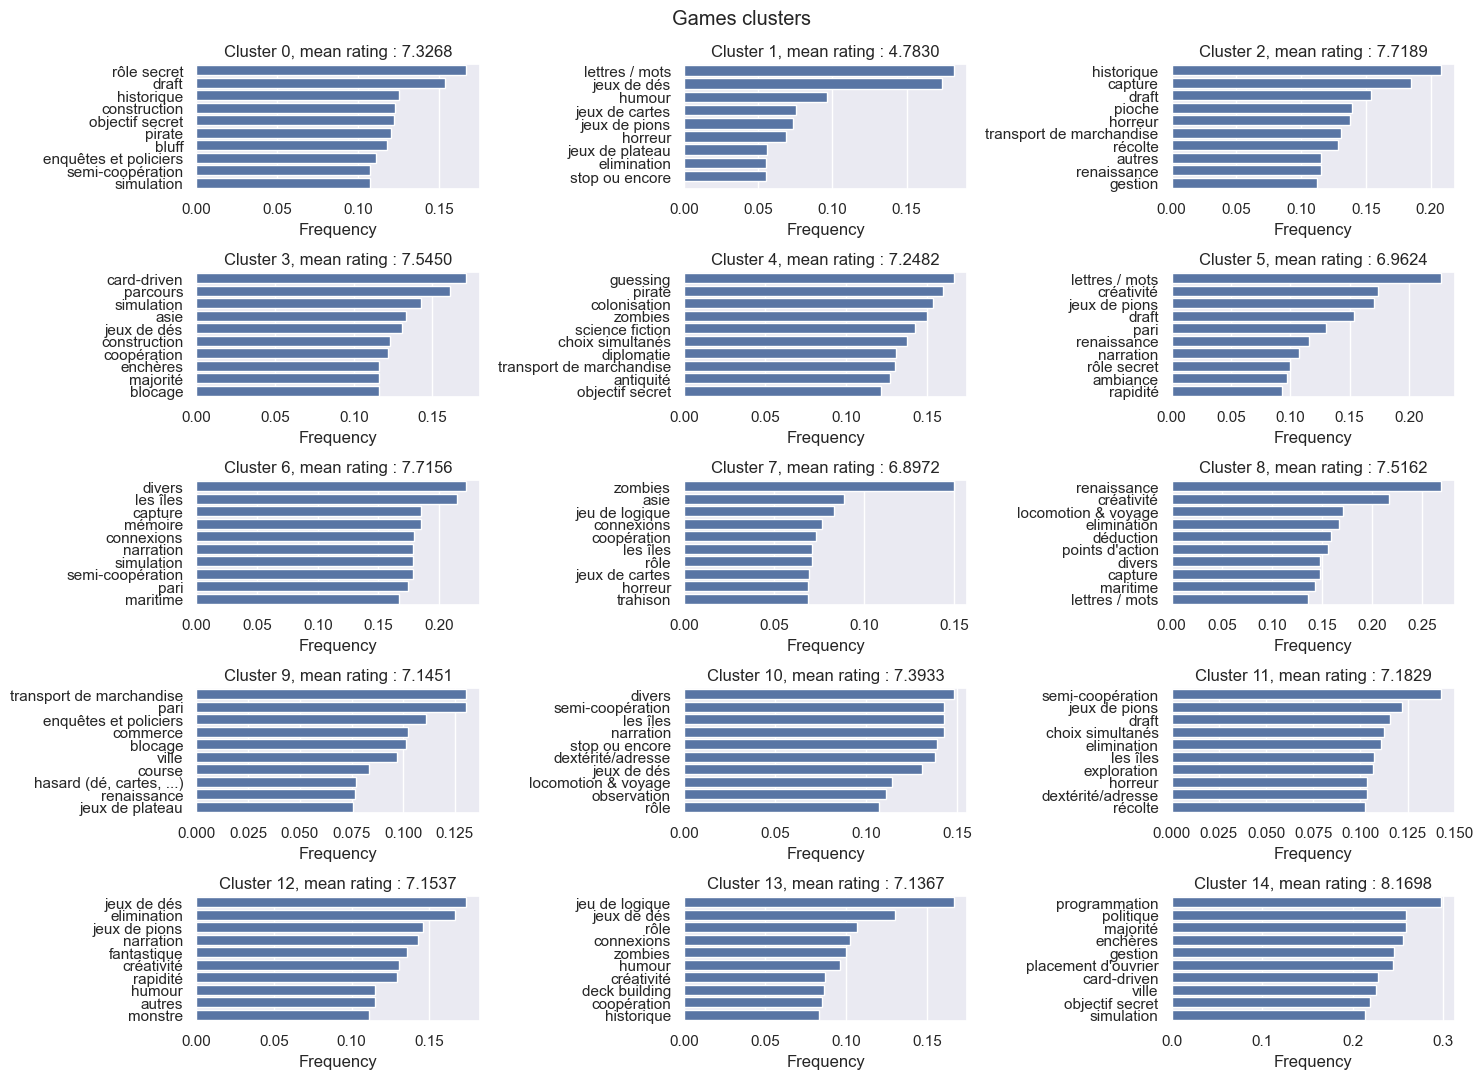

In [345]:
from itertools import product

NROWS, NCOLS = 5, 3
fig, axes = plt.subplots(NROWS, NCOLS, figsize=(15, 11))
for i, j in product(range(NROWS), range(NCOLS)):
    cluster = i * NCOLS + j
    #if cluster > 6:
        #break
    data = sorted[sorted["Cluster"] == cluster]
    bars = sns.barplot(data, y="Type", x="Frequency", ax=axes[i, j])
    bars.set_ylabel("")
    bars.set_yticks(range(10))

    mean_rating = means[means["Cluster"] == cluster][("Rating", "mean")].item()
    bars.set_title(f"Cluster {cluster}, mean rating : {mean_rating:.4f}")

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.suptitle("Games clusters")

In [346]:
CD = games_clusters.pivot_table(index="Game id", columns="Cluster", values="Distance_centroid", fill_value=0).T
CS = games_clusters.pivot_table(index="Game id", columns="Cluster", aggfunc='size', fill_value=0).T
CS = CS / CS.sum(axis=0)
clusters_distances = (1 / (CD @ games_tags / CS.sum(axis=1).values[:, None] )).replace(np.inf, 0)
clusters_tags_dist = clusters_distances * clusters_tags / clusters_distances.sum(axis=1).values[:, None]

clusters_tags_df = clusters_tags_dist.stack().to_frame().reset_index()
clusters_tags_df.columns = ["Cluster", "Type", "Weight"]
#clusters_tags_df.sort_values()
sorted = clusters_tags_df.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Weight', ascending=False).head(10))

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_22791/3987712492.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted = clusters_tags_df.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Weight', ascending=False).head(10))


Text(0.5, 0.98, 'Games clusters (1 / distance from centroid)')

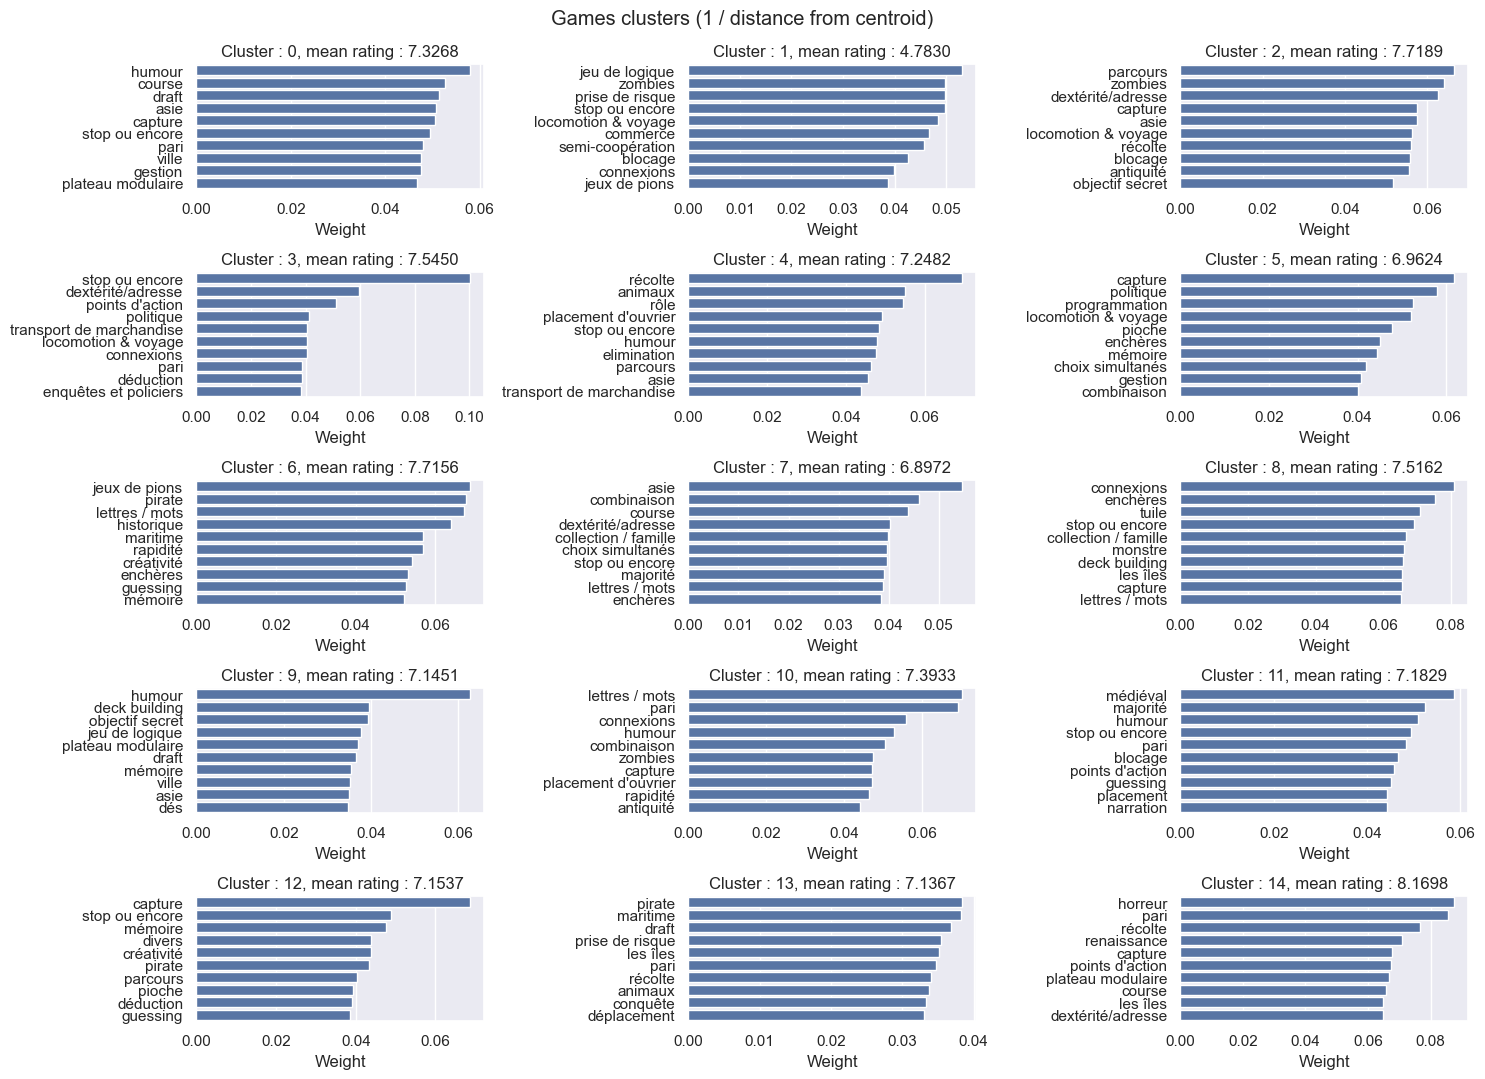

In [347]:
fig, axes = plt.subplots(NROWS, NCOLS, figsize=(15, 11))
for i, j in product(range(NROWS), range(NCOLS)):
    cluster = i * NCOLS + j
    
    data = sorted[sorted["Cluster"] == cluster]
    bars = sns.barplot(data, y="Type", x="Weight", ax=axes[i, j])
    bars.set_ylabel("")
    bars.set_yticks(range(10))

    mean_rating = means[means["Cluster"] == cluster][("Rating", "mean")].item()
    bars.set_title(f"Cluster : {cluster}, mean rating : {mean_rating:.4f}")

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.suptitle("Games clusters (1 / distance from centroid)")

Text(0.5, 1.0, 'Centroids as latent factors')

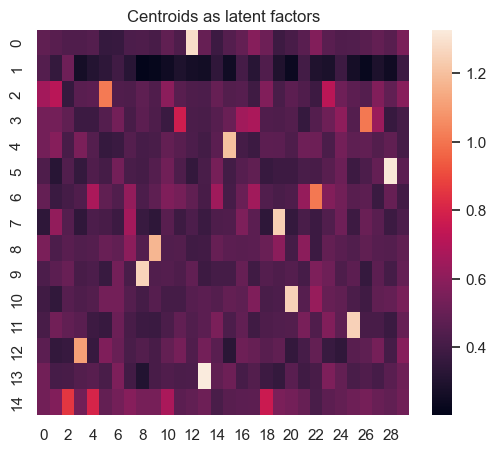

In [348]:
sns.set_theme(rc={"figure.figsize" : (6, 5)})
ax = sns.heatmap(kmeans.cluster_centers_)

ax.set_title("Centroids as latent factors")

| Centroid | Dominant latent factor meaning |
| -------- | ------------------------------ |
| 0        | 12 : narration, pirate, diplomatie |
| 1        |  |
| 2 | 5 : capture, 23 : draft, colonisation, 1 : récolte, politique |
| 3 | 11 : narration, horreur, coopération, 26 : placement d'ouvrier, asie, îles |
| 4 | 15 : enquêtes & policiers |
| 5 | 28 : sémi-coopération, rennaissance |
| 6 | 22 : sémi-coopération |
| 7 | 19 : maritime |
| 8 | 9 : science-fiction |
| 9 | 8 : rennaissance, transport de marchandise |
| 10 | 20 : transport de marchandise |
| 11 | 25 : monstre, maritime |
| 12 | 3 : antiquité, fantastique, gestion de main, deck-building |
| 13 | 13 : points d'action, transport de marchandise, locomotion |
| 14 | 2 : card-driven, enquêtes & policiers, autres, capture |

## Co-occurence matrix

In [349]:
# !!! Important to reorder BEFORE projection
games_tags = games_tags.loc[games_ids]

cooc_matrix = games_tags.T @ games_tags
np.fill_diagonal(cooc_matrix.values, val=0)
cooc_freq = cooc_matrix.apply(sum, axis=1)
cooc_matrix = cooc_matrix.sort_values(by=cooc_matrix.columns.tolist(), ascending=False)

AttributeError: 'ClusterGrid' object has no attribute 'set_title'

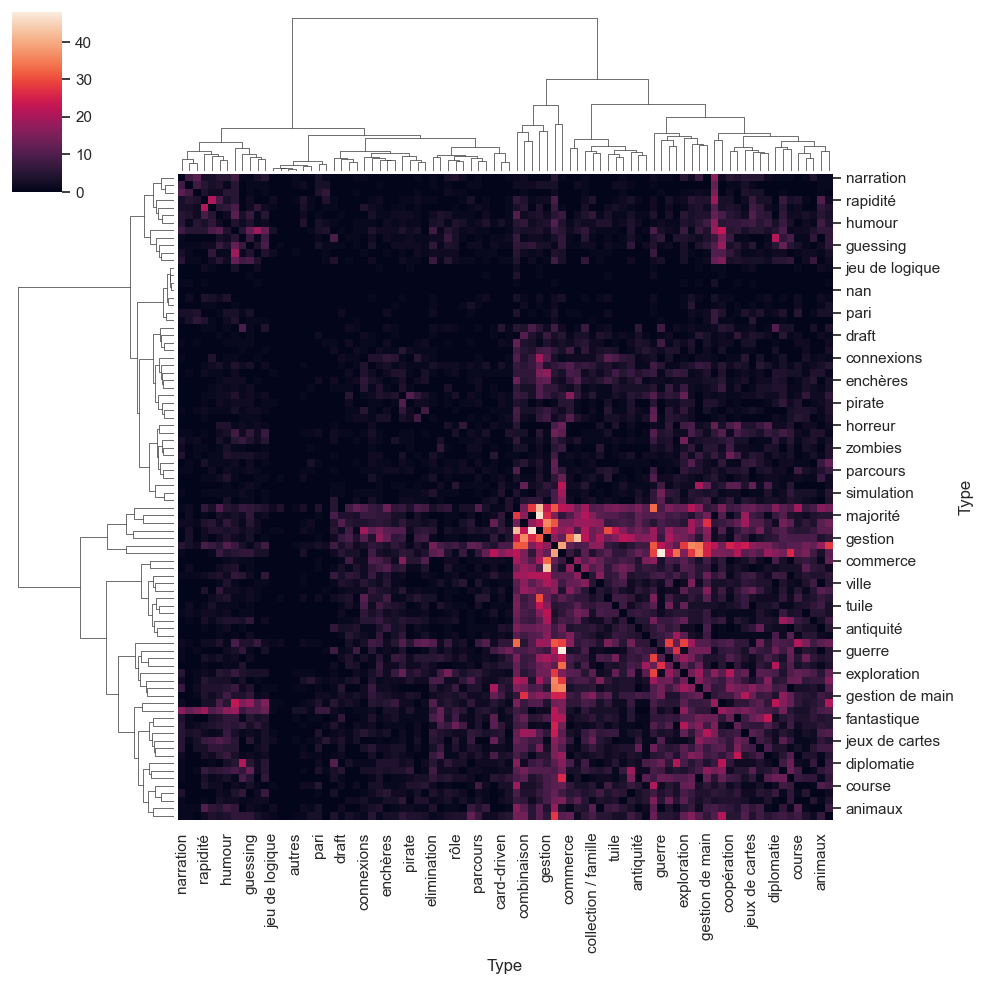

In [404]:
sns.set_theme(rc={"figure.figsize" : (15,9)})
ax = sns.clustermap(cooc_matrix, method="ward")
ax.set_title("Co-occurence matrix cluster")

In [396]:
link_matrix = linkage(cooc_matrix, method="ward", metric="euclidean")
cluster_labels = fcluster(link_matrix, 2, criterion="maxclust")
cluster_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2,
       2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1],
      dtype=int32)

<Axes: xlabel='Type', ylabel='Type'>

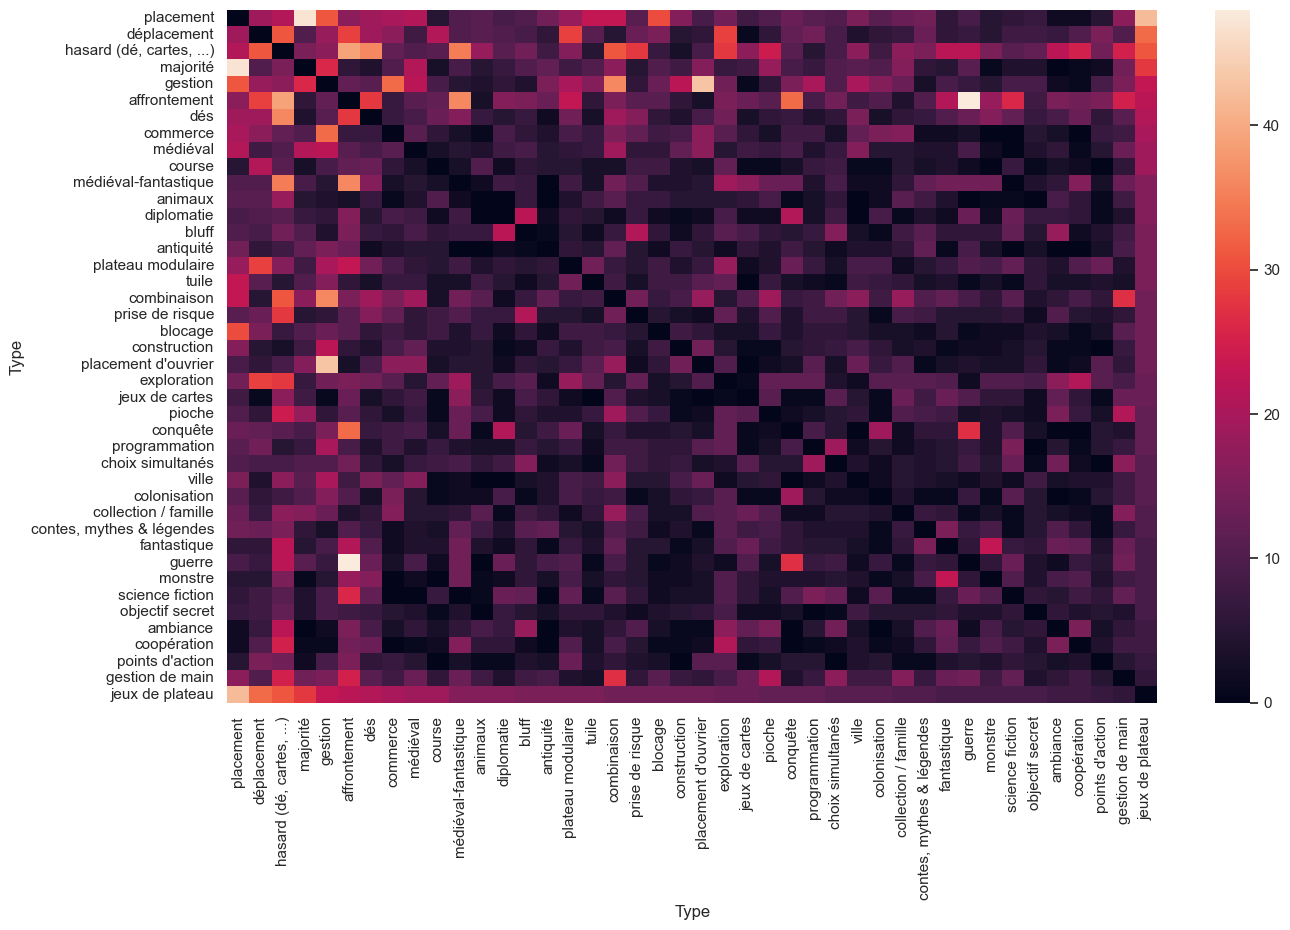

In [405]:
labels = cooc_matrix.index[cluster_labels == 2]
reduced = cooc_matrix.loc[labels, labels]
sns.heatmap(reduced, annot=False)

<Axes: xlabel='Type', ylabel='Type'>

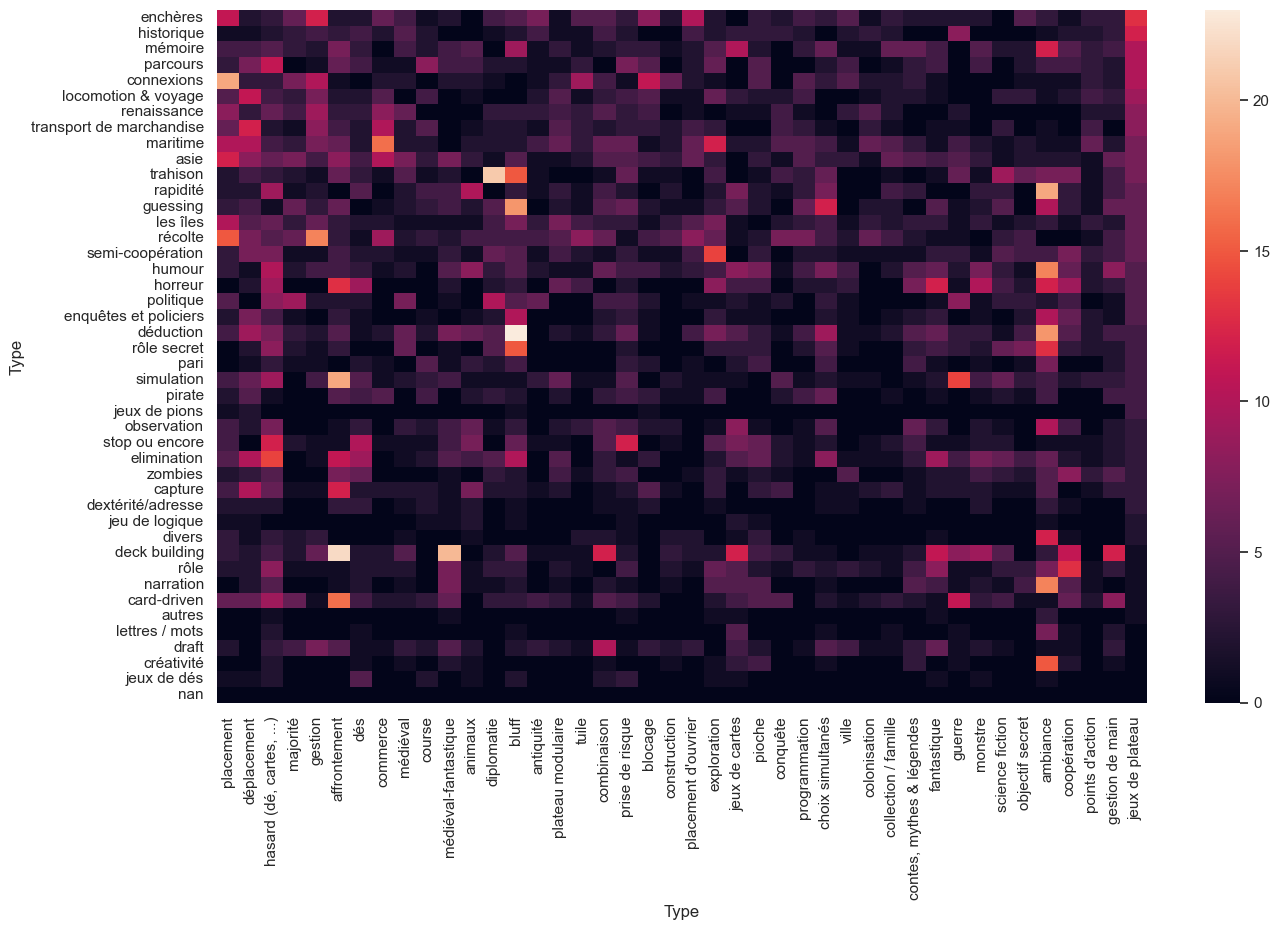

In [407]:
labels = cooc_matrix.index[cluster_labels == 1]
reduced = cooc_matrix.loc[labels, cooc_matrix.index[cluster_labels == 2]]
sns.heatmap(reduced, annot=False)

### Tags projection in latent factors space

Text(0.5, 1.0, 'Tags on latent space')

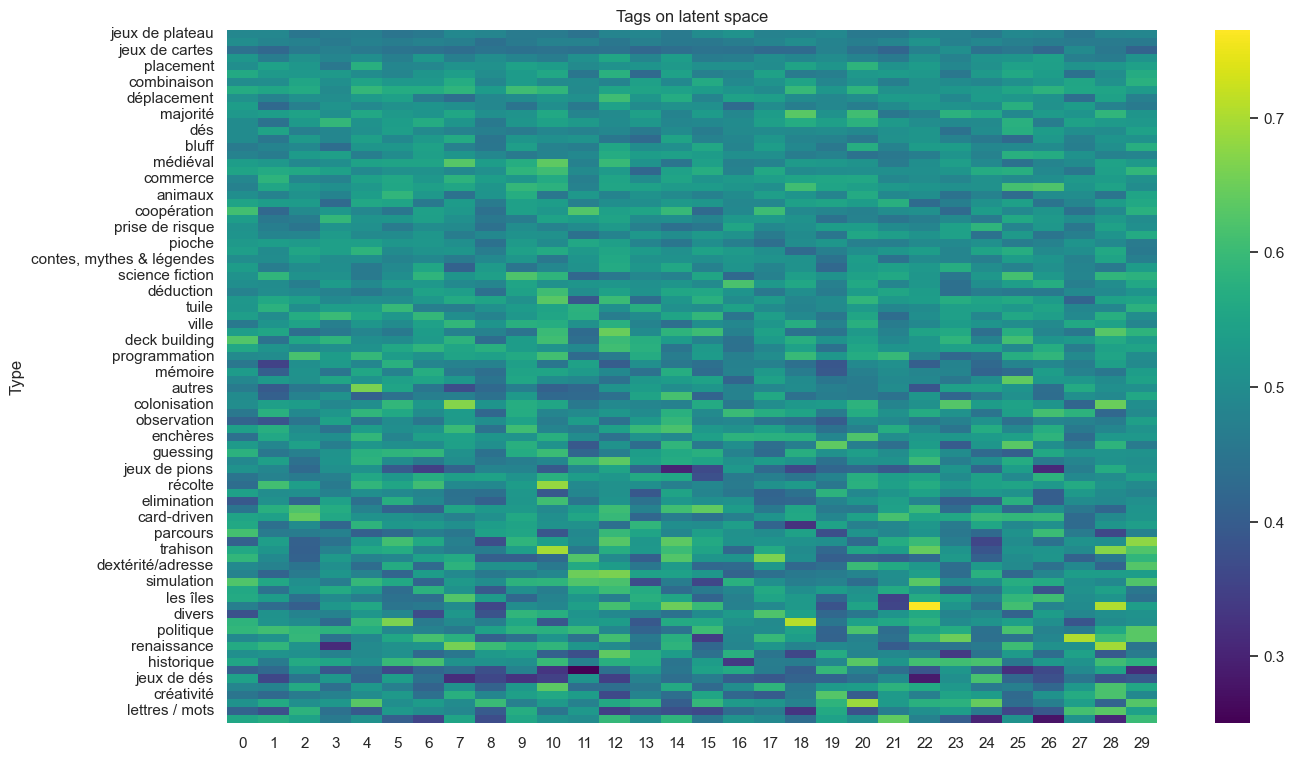

In [413]:
games_count_encode = games_tags / games_tags.sum(axis=0)
# Reordering before projection should be done (see 1st bloc of co occ matrix code)
games_proj = games_count_encode.T @ G

sns.set_theme(rc={'figure.figsize':(15,9)})
ax = sns.heatmap(games_proj, cmap="viridis")
ax.set_title("Tags on latent space")

In [411]:
# COMPONENT = 14
# sns.heatmap(games_proj.loc[:, [COMPONENT]].sort_values(by=COMPONENT).tail(30), cmap="viridis", cbar=True)
# plt.tight_layout()